# EDA

In [208]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from preprocess import get_records, preprocess_for_logistic, read_records
from get_metadata import get_video_metadata
from report import report_performance,make_top_n_pred_df,get_label
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
r = re.compile("^train.+\\.tfrecord$")
train_dir  = "/Users/shufanxia/Documents/frame-level/"
val_dir = "/Users/shufanxia/Documents/validate-frame/"
test_dir = "/Users/shufanxia/Documents/test-frame/"
frames_train = get_records(train_dir,"train")
frames_val = get_records(val_dir,"validate")
frames_all=frames_train+frames_val

feat_rgb,feat_audio,feat_pseudoid,feat_labels = read_records(frames_train)
feat_rgb_val,feat_audio_val,feat_pseudoid_val,feat_labels_val = read_records(frames_val)

2022-04-10 14:52:08.420562: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
feat_labels_all = feat_labels + feat_labels_val
feat_id_all = feat_pseudoid + feat_pseudoid_val
feat_rgb_all = feat_rgb+ feat_rgb_val
n_frames = list(map(len,feat_rgb_all))
n_labels = list(map(len,feat_labels_all))

In [156]:
df = pd.DataFrame({"pseudo_id":feat_id_all,
                    "labels":feat_labels_all,
                    "n_frames":n_frames,
                    "n_labels":n_labels})
print("Total numbers of videos:", len(df))

Total numbers of videos: 5978


In [160]:
df.dtypes

pseudo_id    object
labels       object
n_frames      int64
n_labels      int64
dtype: object

### histogram of n_frames and n_labels

/var/folders/f2/d1mj0jcx0_g5cf_sw9qfpnwc0000gn/T/ipykernel_35447/2805521814.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/f2/d1mj0jcx0_g5cf_sw9qfpnwc0000gn/T/ipykernel_35447/2805521814.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


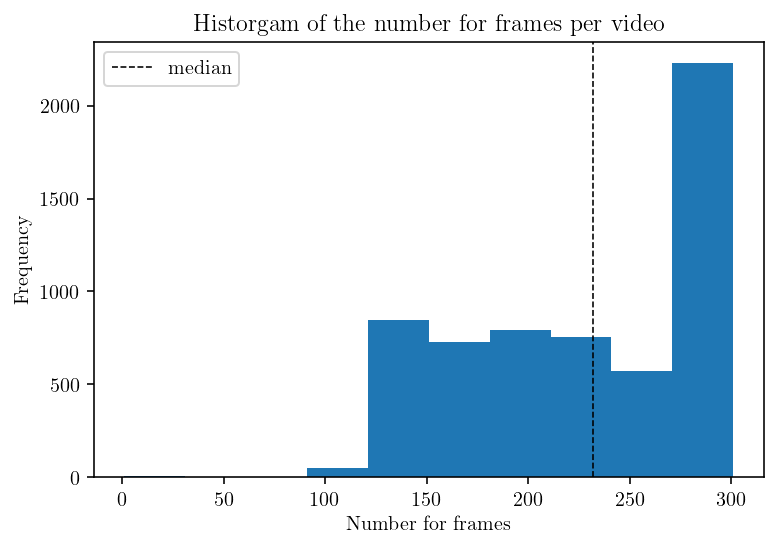

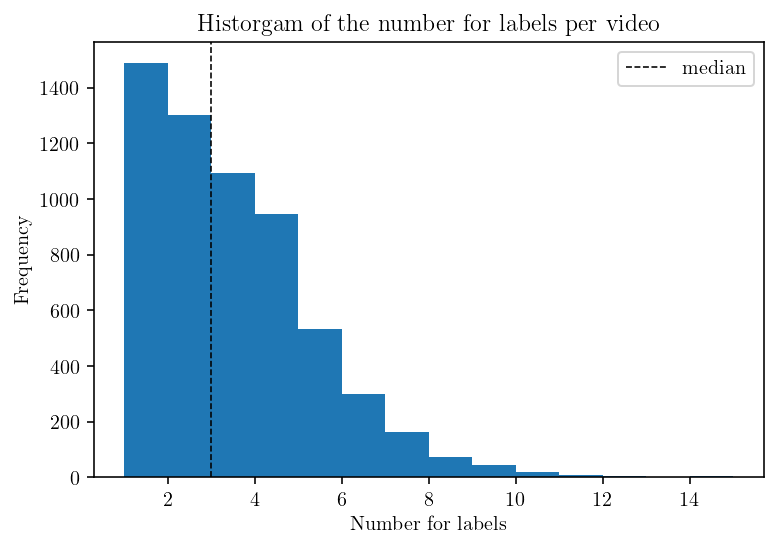

In [19]:
fig,ax = plt.subplots()
ax.hist(df.n_frames)
ax.axvline(x=df.n_frames.median(),color='k', lw=0.8, ls='--',label="median")
ax.legend()
ax.set_xlabel("Number for frames")
ax.set_ylabel("Frequency")
ax.set_title("Historgam of the number for frames per video")
fig.show()

fig,ax = plt.subplots()
ax.hist(df.n_labels,bins=np.arange(1,df.n_labels.max()+1,1))
ax.axvline(x=df.n_labels.median(),color='k', lw=0.8, ls='--',label="median")
ax.legend()
ax.set_xlabel("Number for labels")
ax.set_ylabel("Frequency")
ax.set_title("Historgam of the number for labels per video")
fig.show()

### bar plot of label frequency

In [92]:
all_labels_merge = np.concatenate(df.labels.values)
counter = np.bincount(all_labels_merge)
labels = np.arange(0,np.max(all_labels_merge)+1,1)
label_count = np.array([counter[i]for i in labels])

In [100]:
top_labels = labels[np.argsort(label_count)[::-1]]
label_count_sorted = np.sort(label_count)[::-1]

In [99]:
np.sum(label_count_sorted >100)

26

In [112]:
label_dict = pd.read_csv("vocabulary.csv")

topN = 30
topN_labels = top_labels[:topN]
topN_labelnames = get_label(topN_labels,4000,label_dict,get_names=True)
topN_labelnames = [str(topN_labels[i])+": "+topN_labelnames[i] for i in range(topN)]
topNcount = label_count_sorted[:topN]


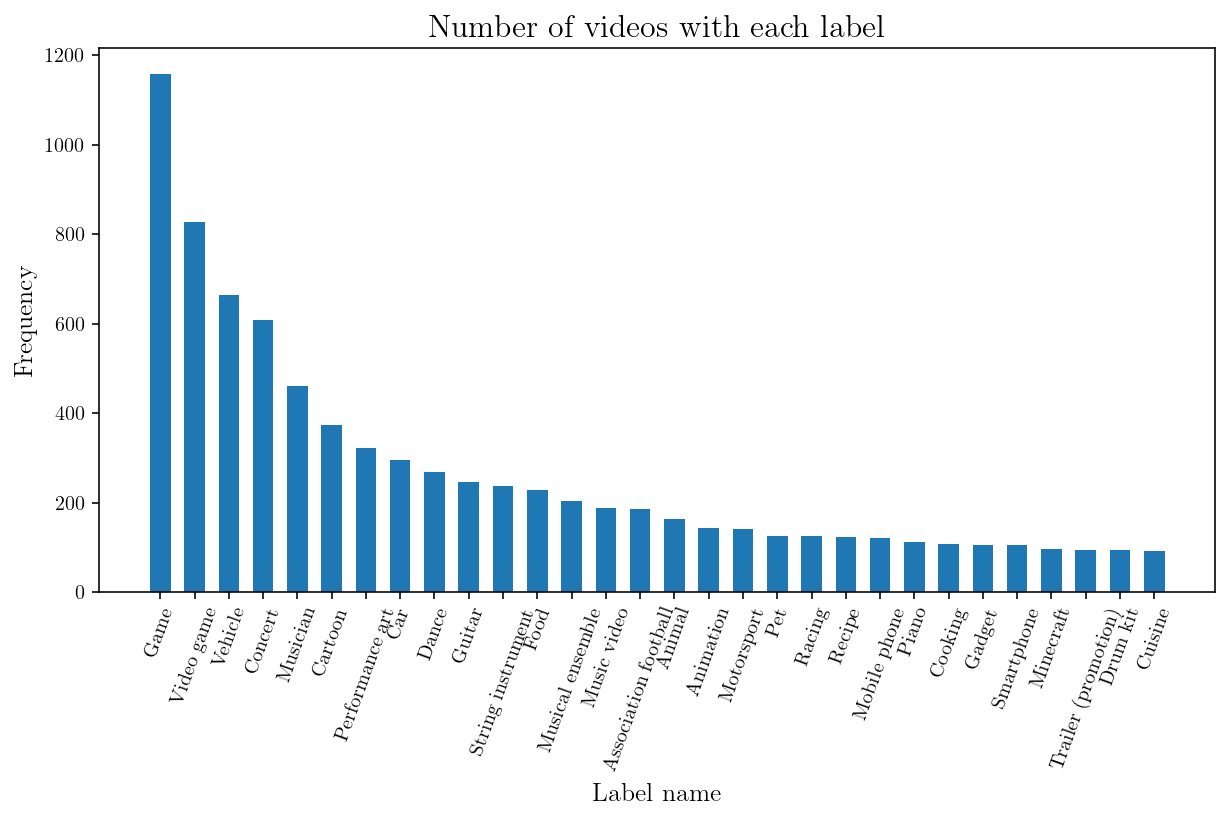

In [114]:
fig = plt.figure(figsize=(10,5))
x =  np.arange(0,topN,1)
plt.bar(x,topNcount,width=0.6)
plt.xticks(x,topN_labelnames,rotation=70)
plt.xlabel("Label name",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Number of videos with each label",fontsize=16)
plt.show()


#### Looking at video cateogries

In [ ]:
metadata_df = list(map(get_video_metadata,df.pseudo_id.values))

col_names = ["pseudo_id","real_id",
    "title","categories",
    "tags","description",
    "is_live","view_count",
    "like_count","channel_url",
    "duration","average_rating",
    "age_limit","webpage_url",
]
metadata_df = pd.DataFrame(metadata_df, columns=col_names)

In [164]:
metadata_df.to_pickle("video_metadata.pkl")
df.to_csv("video_id_label.csv",index=False)

In [166]:
metadata_df = pd.read_pickle("video_metadata.pkl")
df = pd.read_csv("video_id_label.csv")
video_info = metadata_df.merge(df,left_on="pseudo_id",right_on="pseudo_id")

In [167]:
video_info.head()

,pseudo_id,real_id,title,categories,tags,description,is_live,view_count,like_count,channel_url,duration,average_rating,age_limit,webpage_url,labels,n_frames,n_labels
0,lKbF,CXg4IMG3e7k,F1 2012 Felipe Massa Could Face Leaving Ferrar...,[Gaming],"[Felipe, Massa, Could, Face, Leaving, Ferrari,...",INFORMATION ON F1 2012 TESTING HERE:\r\nhttp:/...,NaN,6058.0,19.0,https://www.youtube.com/channel/UCnIC43govFqg6...,288.0,NaN,0.0,https://www.youtube.com/watch?v=CXg4IMG3e7k,"[1, 19, 2852, 3477]",287,4
1,HebF,koPinjfqp9w,la arrolladora en ecatepec 14 julio 2012 irrev...,[Music],[CIMG2261],,NaN,2599.0,4.0,https://www.youtube.com/channel/UCtAj-jNesMTrG...,176.0,NaN,0.0,https://www.youtube.com/watch?v=koPinjfqp9w,"[3, 6]",176,2
2,GkbF,tLxlqIXkc7A,Fall Fashion 2012! | MEGHAN HUGHES,[Howto & Style],"[missmeghanmakeup, msmeghanmakeup, missmeghanv...",'Like' this video if you liked it! \n\nI hope ...,NaN,45770.0,1020.0,https://www.youtube.com/channel/UChZUCgX-hBXDp...,199.0,NaN,0.0,https://www.youtube.com/watch?v=tLxlqIXkc7A,[66],199,1
3,q2bF,aHEH_eDsBXo,MENTALPSICOSIS - La Flecha (VÍDEO OFICIAL),[Music],[],BANDA: La Flecha\nTITULO:Mentalpsicosis\nALBUM...,NaN,4805.0,65.0,https://www.youtube.com/channel/UCr6jqjWdZw57t...,247.0,NaN,0.0,https://www.youtube.com/watch?v=aHEH_eDsBXo,[14],247,1
4,aUbF,n2DkgwnNLCQ,Le Monstre Wooden Roller Coaster POV Front Sea...,[Travel & Events],"[Le, Monstre, Wooden, Roller, Coaster, POV, Fr...",Filmed & Edited by Robb Alvey - http://www.the...,NaN,94443.0,466.0,https://www.youtube.com/channel/UCT-LpxQVr4Jlr...,333.0,NaN,0.0,https://www.youtube.com/watch?v=n2DkgwnNLCQ,"[141, 247, 255]",300,3


In [200]:
#video_category =np.unique(video_info.categories.values)
video_info.categories = video_info.categories.astype("str").apply(lambda x: re.sub(r"\[|\]|\'|\'","",x))
category_count = video_info.categories.value_counts()

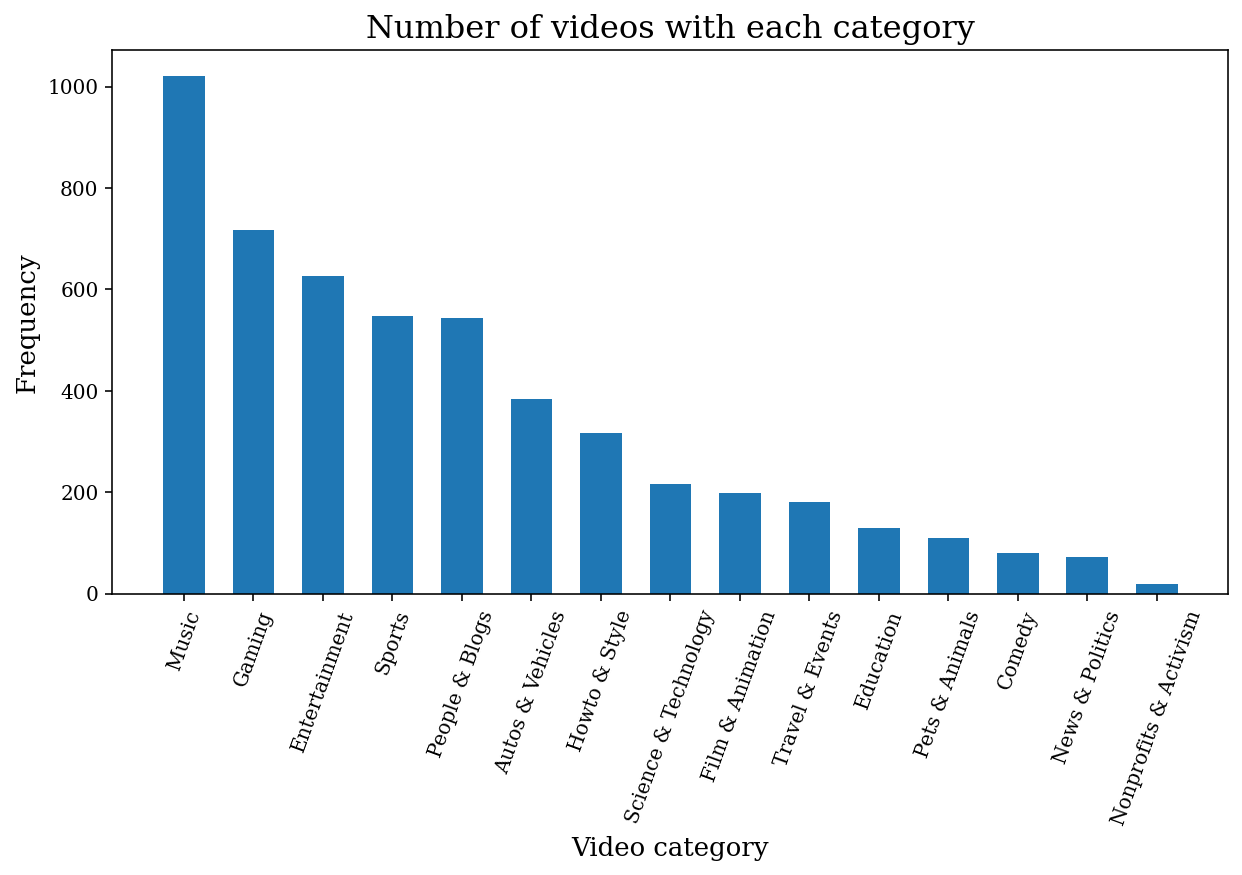

In [209]:
fig = plt.figure(figsize=(10,5))
n_cat = len(category_count)
x =  np.arange(0,n_cat,1)
category_names = category_count.index
plt.bar(x,category_count.values,width=0.6)
plt.xticks(x,category_names,rotation=70)
plt.xlabel("Video category",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Number of videos with each category",fontsize=16)
plt.show()

#### Average Numbers of labels by video category

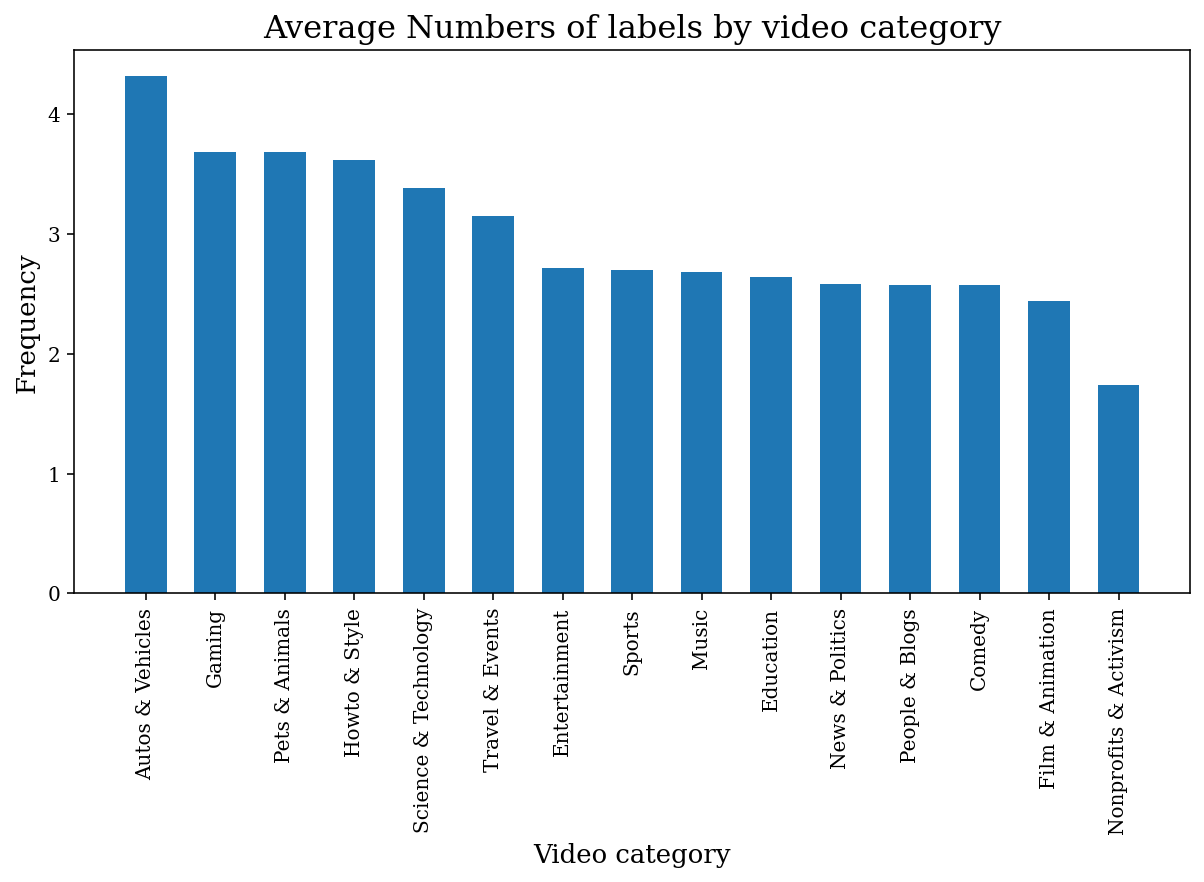

In [229]:
mean_Nlabels_by_cat = video_info.groupby('categories')['n_labels'].mean()

fig = plt.figure(figsize=(10,5))
n_cat = len(mean_Nlabels_by_cat)
x =  np.arange(0,n_cat,1)
category_names = mean_Nlabels_by_cat.index[np.argsort(mean_Nlabels_by_cat.values)[::-1]]
plt.bar(x,np.sort(mean_Nlabels_by_cat.values)[::-1],width=0.6)
plt.xticks(x,category_names,rotation=90)
plt.xlabel("Video category",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Average Numbers of labels by video category",fontsize=16)
plt.show()

##### Numbers of labels associated with each vertical category in vocabulary dictionary

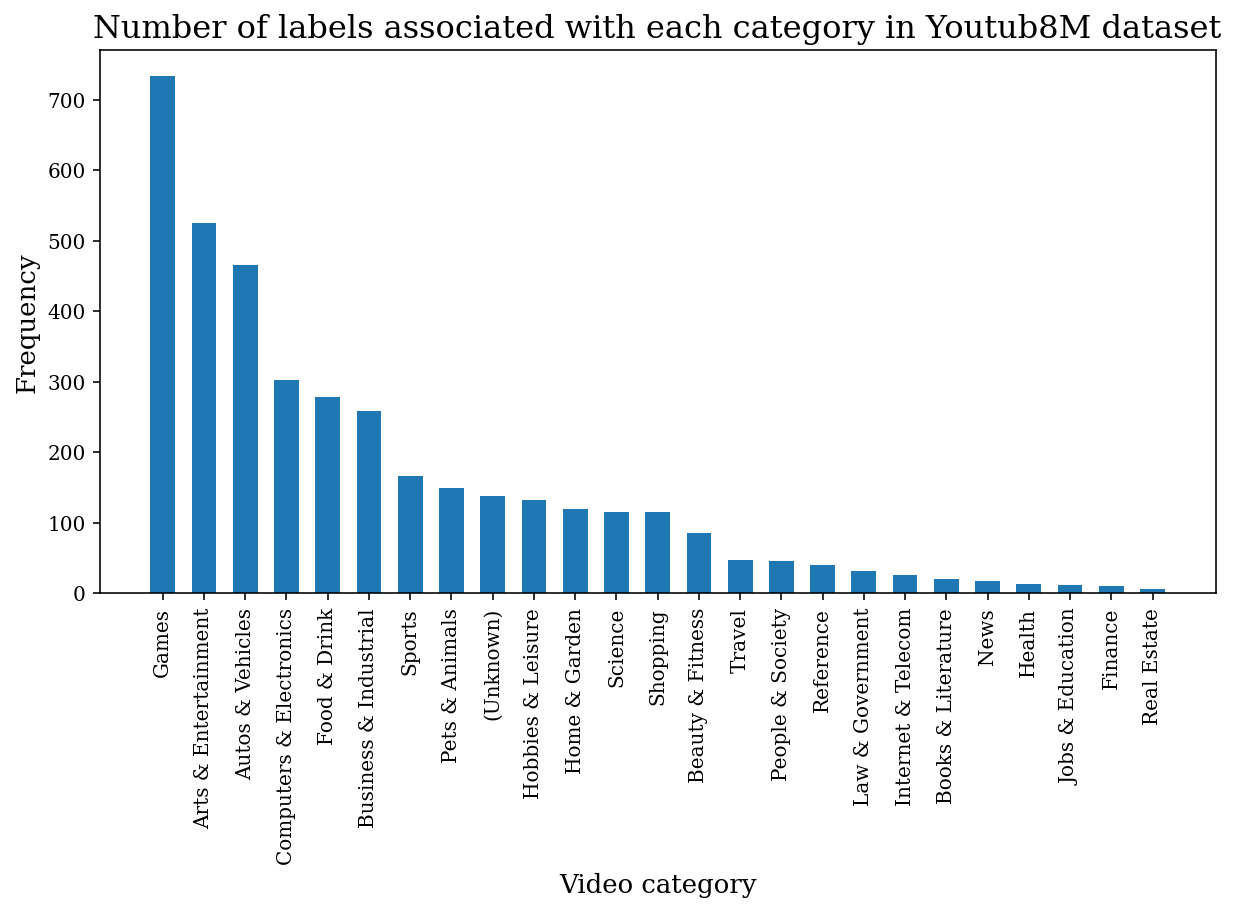

In [224]:
label_cat_count = label_dict.groupby(['Vertical1'])['Index'].count()

fig = plt.figure(figsize=(10,5))
n_cat = len(label_cat_count)
x =  np.arange(0,n_cat,1)

category_names = label_cat_count.index[np.argsort(label_cat_count.values)[::-1]]
plt.bar(x,np.sort(label_cat_count.values)[::-1],width=0.6)
plt.xticks(x,category_names,rotation=90)
plt.xlabel("Video category",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Number of labels associated with each category in Youtub8M dataset",fontsize=16)
plt.show()


#### numbers of labels associated with each category in our data

In [ ]:
df_label_cat_subset = label_dict[]

In [ ]:
fig = plt.figure(figsize=(10,5))
n_cat = len(label_cat_count)
x =  np.arange(0,n_cat,1)

category_names = label_cat_count.index[np.argsort(label_cat_count.values)[::-1]]
plt.bar(x,np.sort(label_cat_count.values)[::-1],width=0.6)
plt.xticks(x,category_names,rotation=90)
plt.xlabel("Video category",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.title("Number of labels associated with each category in Youtub8M dataset",fontsize=16)
plt.show()
